In [1]:
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch

use_cuda = torch.cuda.is_available()

In [2]:
number_of_class = 6
# how many data per batch to load
batch_size = 10000
# data split ratio
train_ratio = 0.95
test_ratio = 0.1

n_epochs = 1000

lr=0.05

In [3]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [4]:
# make number of data for each class equal
#
from collections import Counter

class_counter = Counter()

class_names =['class_' + str(i) for i in range(number_of_class)]
for class_name in class_names:
    class_counter[class_name] = 0
for i in train['class']:
    class_counter['class_' + str(i)] += 1

print('Before:')
print(class_counter)

max_count = -np.Inf
for i in range(number_of_class):
    if class_counter['class_' + str(i)] > max_count:
        max_count = class_counter['class_' + str(i)]

train_classified = [train[train['class'] == i] for i in range(number_of_class)]

for i in range(number_of_class):
    num_need_resample = max_count - class_counter['class_' + str(i)]
    num_resample_batch = num_need_resample // class_counter['class_' + str(i)]
    num_resample_leftover = num_need_resample % class_counter['class_' + str(i)]
    for j in range(num_resample_batch):
        add_df = train_classified[i]
        train =  pd.concat([train, add_df[0:dist_class[i][1]]], ignore_index=True)
        train =  train.append(df_to_be_added)
        
    df_to_be_added = train_classified[i][:num_resample_leftover]
    train =  train.append(df_to_be_added)

class_names =[i for i in range(number_of_class)]
for class_name in class_names:
    class_counter[class_name] = 0
for i in train['class']:
    class_counter[i] += 1

print('After:')
print(class_counter)

Before:
Counter({'class_0': 1611, 'class_2': 1478, 'class_5': 1411, 'class_1': 920, 'class_3': 889, 'class_4': 851})
After:
Counter({'class_0': 1611, 0: 1611, 1: 1611, 2: 1611, 3: 1611, 4: 1611, 5: 1611, 'class_2': 1478, 'class_5': 1411, 'class_1': 920, 'class_3': 889, 'class_4': 851})


In [5]:
all_data = pd.concat((train.loc[:,'appearedTimeOfDay':'cooc_151'],
                      test.loc[:,'appearedTimeOfDay':'cooc_151']))
id = test['id']

In [6]:
# all_data.head()

In [7]:
all_data = all_data.applymap(lambda x: 1.0 if x == True else x)
all_data = all_data.applymap(lambda x: 0.0 if x == False else x)
all_data = pd.get_dummies(all_data)
# numeric_feats = df.dtypes[df.dtypes != "object"].index
# df = df[numeric_feats]
apearedHour = all_data['appearedHour']
appearedMinute = all_data['appearedMinute']
appearedTimeDayCycle = apearedHour * 60 + appearedMinute
appearedTimeDayCycle = np.sin(appearedTimeDayCycle / (24 * 60) * 2 * np.pi)
# print('appearedTimeDayCycle= ',appearedTimeDayCycle)
all_data = all_data.drop(['appearedHour'], axis=1)
all_data = all_data.drop(['appearedMinute'], axis=1)
all_data['appearedTimeDayCycle'] = appearedTimeDayCycle

# df = df.drop(['temperature'], axis=1)
# df = df.drop(['windSpeed'], axis=1)
# df = df.drop(['pressure'], axis=1)
# df = df.drop(['gymIn100m'], axis=1)
# df = df.drop(['gymIn250m'], axis=1)
# df = df.drop(['gymIn500m'], axis=1)
# df = df.drop(['gymIn1000m'], axis=1)
# df = df.drop(['gymIn2500m'], axis=1)
# df = df.drop(['gymIn5000m'], axis=1)
# df = df.drop(['rural'], axis=1)
# df = df.drop(['midurban'], axis=1)
# df = df.drop(['suburban'], axis=1)
# df = df.drop(['urban'], axis=1)
# df = df.drop(['pokestopIn100m'], axis=1)
# df = df.drop(['pokestopIn250m'], axis=1)
# df = df.drop(['pokestopIn500m'], axis=1)
# df = df.drop(['pokestopIn1000m'], axis=1)
# df = df.drop(['pokestopIn2500m'], axis=1)
# df = df.drop(['pokestopIn5000m'], axis=1)
# df = df.drop(['terrainType'], axis=1)
# df = df.drop(['closeToWater'], axis=1)


In [8]:
# all_data.head()

In [9]:
# list(all_data.columns.values)

In [10]:
#let's look at the data :
# matplotlib.rcParams['figure.figsize'] = (6.0, 6.0)

# data = pd.DataFrame({"x":df['population_density'], "y":targets})

# data.plot(x = "x", y = "y",kind = "scatter")

In [11]:
#normailize to 0-1
for k in all_data.columns.values:
    if (all_data[k].max() - all_data[k].min()) > 0:
        all_data[k] = (all_data[k] - all_data[k].min())/(all_data[k].max() - all_data[k].min())
    else:
        all_data[k] = 0

In [12]:
# all_data.head()

In [13]:
features = all_data[:train.shape[0]]
features_test = all_data[train.shape[0]:]
targets = train['class']

features.info()
features.shape

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9666 entries, 0 to 1088
Columns: 297 entries, terrainType to appearedTimeDayCycle
dtypes: float64(272), int64(25)
memory usage: 22.0 MB


(9666, 297)

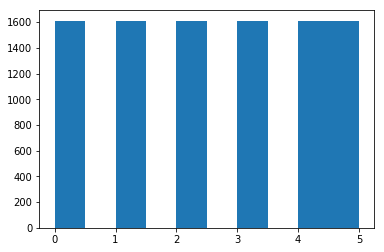

In [14]:
a = plt.hist(targets)

In [15]:
from sklearn.model_selection import train_test_split
# split the data into training and validation sets

X_train, X_valid, y_train, y_valid = train_test_split(features.values, targets.values, test_size = 1 - train_ratio, stratify=targets.values, random_state=0)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = test_ratio, stratify=y_valid, random_state=0)
X_train.shape,X_valid.shape,X_test.shape

((9182, 297), (435, 297), (49, 297))

train_ratio = 0.98

test_ratio = 0.2

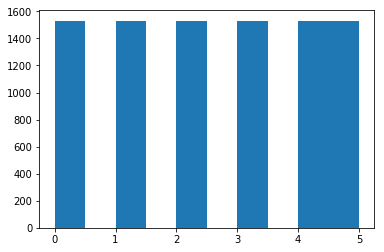

In [16]:
# plt.hist(y_test)
# plt.hist(y_valid)
a =plt.hist(y_train)

In [17]:
import torch.utils.data as data_utils

data_train = data_utils.TensorDataset(torch.from_numpy(X_train).type((torch.FloatTensor)), torch.from_numpy(y_train).type((torch.LongTensor)))
data_valid = data_utils.TensorDataset(torch.from_numpy(X_valid).type((torch.FloatTensor)), torch.from_numpy(y_valid).type((torch.LongTensor)))
data_test = data_utils.TensorDataset(torch.from_numpy(X_test).type((torch.FloatTensor)), torch.from_numpy(y_test).type((torch.LongTensor)))

In [18]:


# convert data to torch.FloatTensor

loaders = {}
loaders['train'] = torch.utils.data.DataLoader(data_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          num_workers=1)

loaders['valid'] = torch.utils.data.DataLoader(data_valid,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)
loaders['test'] = torch.utils.data.DataLoader(data_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          num_workers=1)

In [19]:
# for batch_idx, (data, target) in enumerate(loaders['train']):
#     print(target)

In [20]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    ### TODO: choose an architecture, and complete the class
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(297, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 6)
        self.dropout = nn.Dropout(0.3)




    def forward(self, x):
        x = F.sigmoid(self.fc1(x))
#         x = self.dropout(x)
        x = F.sigmoid(self.fc2(x))
#         x = self.dropout(x)
        x = F.sigmoid(self.fc3(x))


        return x

#-#-# You do NOT have to modify the code below this line. #-#-#

# instantiate the CNN
model = Net()
def init_weights(m):
        print(m)
        if type(m) == nn.Linear:
            m.weight.data.fill_(1.0)
            print(m.weight)
            
def init_ortho(m):
    print()
    if type(m) == nn.Linear:
        nn.init.orthogonal_(m.weight)
        print(m.weight)

# use the modules apply function to recursively apply the initialization
# model.apply(init_ortho)

# move tensors to GPU if CUDA is available
if use_cuda:
    model.cuda()

In [21]:
import torch.optim as optim

### TODO: select loss function
criterion = nn.CrossEntropyLoss()

### TODO: select optimizer

optimizer = optim.Adam(model.parameters(), lr=lr)
# optimizer = optim.Adamax(model.parameters(), lr=0.01)
# optimizer = optim.SGD(model.parameters(), lr=0.01,weight_decay= 1e-6, momentum = 0.9, nesterov = True)
# optimizer = optim.SGD(model.parameters(), lr=0.01)

In [22]:
import time

def train(n_epochs, loaders, model, optimizer, criterion, use_cuda, save_path):
    """returns trained model"""
    # initialize tracker for minimum validation loss
    valid_loss_min = np.Inf 
    
    for epoch in range(1, n_epochs+1):
        # initialize variables to monitor training and validation loss
        train_loss = 0.0
        valid_loss = 0.0
        
        start = time.time()
        
        ###################
        # train the model #
        ###################
        model.train()
        for batch_idx, (data, target) in enumerate(loaders['train']):

#             data = data.type((torch.FloatTensor))

            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()
            # clear the gradients of all optimized variables
            optimizer.zero_grad()
            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # backward pass: compute gradient of the loss with respect to model parameters
            loss.backward()
            # perform a single optimization step (parameter update)
            optimizer.step()
            # update accumulated training loss
            train_loss += loss.item()*data.size(0)
            
        ######################    
        # validate the model #
        ######################
        model.eval()
        for batch_idx, (data, target) in enumerate(loaders['valid']):
            
#             data = data.type((torch.FloatTensor))
            # move to GPU
            if use_cuda:
                data, target = data.cuda(), target.cuda()

            # forward pass: compute predicted outputs by passing inputs to the model
            output = model(data)
            # calculate the batch loss
            loss = criterion(output, target)
            # update accumulated validation loss 
            valid_loss += loss.item()*data.size(0)
            

        train_loss = train_loss/len(loaders['train'].dataset)
        valid_loss = valid_loss/len(loaders['valid'].dataset)
        
        # print training/validation statistics 
        print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f} \t time: {:.1f}'.format(
            epoch, 
            train_loss,
            valid_loss,
            time.time() - start
            ))
        
        ## TODO: save the model if validation loss has decreased
        if valid_loss < valid_loss_min:
            print('Validation loss decreased from {:.6f} to {:.6f}. Model was saved'.format(
                valid_loss_min,
                valid_loss
            ))
            
            torch.save(model.state_dict(), save_path)
            valid_loss_min = valid_loss
    
    # return trained model
    return model


# train the model
model = train(n_epochs, loaders, model, optimizer, 
                      criterion, use_cuda, 'model.pt')

/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


Epoch: 1 	Training Loss: 1.795349 	Validation Loss: 1.806525 	 time: 0.3
Validation loss decreased from inf to 1.806525. Model was saved
Epoch: 2 	Training Loss: 1.806869 	Validation Loss: 1.796872 	 time: 0.3
Validation loss decreased from 1.806525 to 1.796872. Model was saved
Epoch: 3 	Training Loss: 1.797095 	Validation Loss: 1.791481 	 time: 0.3
Validation loss decreased from 1.796872 to 1.791481. Model was saved
Epoch: 4 	Training Loss: 1.791602 	Validation Loss: 1.789828 	 time: 0.3
Validation loss decreased from 1.791481 to 1.789828. Model was saved
Epoch: 5 	Training Loss: 1.789783 	Validation Loss: 1.786756 	 time: 0.3
Validation loss decreased from 1.789828 to 1.786756. Model was saved
Epoch: 6 	Training Loss: 1.786633 	Validation Loss: 1.779005 	 time: 0.3
Validation loss decreased from 1.786756 to 1.779005. Model was saved
Epoch: 7 	Training Loss: 1.779274 	Validation Loss: 1.765309 	 time: 0.3
Validation loss decreased from 1.779005 to 1.765309. Model was saved
Epoch: 8 	T

Epoch: 215 	Training Loss: 1.329372 	Validation Loss: 1.419149 	 time: 0.4
Epoch: 216 	Training Loss: 1.328865 	Validation Loss: 1.416587 	 time: 0.4
Validation loss decreased from 1.417114 to 1.416587. Model was saved
Kaggle score = 0.54438 (0.0006 IMPROVEMENT)

Epoch: 216 	Training Loss: 1.326797 	Validation Loss: 1.396590 	 time: 0.7
Epoch: 217 	Training Loss: 1.326093 	Validation Loss: 1.396514 	 time: 0.7
Epoch: 218 	Training Loss: 1.325473 	Validation Loss: 1.394434 	 time: 0.6
Validation loss decreased from 1.396026 to 1.394434. Model was saved
Kaggle score = 55245 (0.011 IMPROVEMENT)

Epoch: 364 	Training Loss: 1.229904 	Validation Loss: 1.381198 	 time: 0.3
Validation loss decreased from 1.384373 to 1.381198. Model was saved
Epoch: 365 	Training Loss: 1.231026 	Validation Loss: 1.394960 	 time: 0.3
Epoch: 366 	Training Loss: 1.231521 	Validation Loss: 1.379200 	 time: 0.3
Validation loss decreased from 1.381198 to 1.379200. Model was saved
Epoch: 367 	Training Loss: 1.232151 	Validation Loss: 1.395807 	 time: 0.3
Epoch: 368 	Training Loss: 1.230561 	Validation Loss: 1.391226 	 time: 0.3


In [23]:
def test(loaders, model, criterion, use_cuda):

    # monitor test loss and accuracy
    test_loss = 0.
    correct = 0.
    total = 0.

    model.eval()
    for batch_idx, (data, target) in enumerate(loaders['test']):
        
#         data = data.type((torch.FloatTensor))
        # move to GPU
        if use_cuda:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(data)
        # calculate the loss
        loss = criterion(output, target)
        # update average test loss 
        test_loss = test_loss + ((1 / (batch_idx + 1)) * (loss.data - test_loss))
        # convert output probabilities to predicted class
        pred = output.data.max(1, keepdim=True)[1]
        # compare predictions to true label
        correct += np.sum(np.squeeze(pred.eq(target.data.view_as(pred))).cpu().numpy())
        total += data.size(0)
            
    print('Test Loss: {:.6f}\n'.format(test_loss))

    print('\nTest Accuracy: %2d%% (%2d/%2d)' % (
        100. * correct / total, correct, total))

# load the model that got the best validation accuracy
model.load_state_dict(torch.load('model.pt'))
# call test function    
test(loaders, model, criterion, use_cuda)

Test Loss: 1.298795


Test Accuracy: 65% (32/49)


/home/jovyan/.local/lib/python3.6/site-packages/torch/nn/functional.py:1332: UserWarning: nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.
  warnings.warn("nn.functional.sigmoid is deprecated. Use torch.sigmoid instead.")


In [24]:
# i,l = next(iter(loaders['test']))
# if use_cuda:
#     i, l = i.cuda(), l.cuda()

# output = model(i)

# result = output.cpu().data.max(1, keepdim=True)[1].numpy()
# result[:,0]

In [25]:
# d = result[:,0]
# plt.hist(d)

NameError: name 'result' is not defined

In [ ]:
plt.hist(l.cpu().numpy())

In [ ]:
features_test_data = torch.tensor(features_test.values).type((torch.FloatTensor))
if use_cuda:
    features_test_data = features_test_data.cuda()
predicted_class = model(features_test_data)
# We will look at the predicted prices to ensure we have something sensible.
predicted_class = predicted_class.data.cpu().max(1, keepdim=True)[1].numpy()[:,0]
predicted_class

In [ ]:
solution = pd.DataFrame({"ID":id, "class":predicted_class})
solution.to_csv("pokemon_sol.csv", index = False)